# 毕业论文`GRAD`
## `MCIP`气象场分析

---
*@author: Evan*\
*@date: 2024-04-02*

In [1]:
import numpy as np
import xarray as xr
import os

import sys
sys.path.append('../../../src/')
from namelist import *
from mask import polygon_to_mask, average_data
from spatial import map_noneobs, diff_noneobs

# silence the warning note
import warnings
warnings.filterwarnings("ignore")

In [2]:
def calculate_dewpoint_from_specific_humidity(temperature, specific_humidity):
    
    # 计算水汽压
    e = specific_humidity * 6.112 * np.exp(17.67 * temperature / (temperature + 243.5))
    
    # 计算露点温度
    dewpoint = (243.5 * np.log(e / 6.112)) / (17.67 - np.log(e / 6.112))
    
    return dewpoint

def calculate_dewpoint_from_relative_humidity(temperature, relative_humidity):
    
    A = 17.625
    B = 243.04
    alpha = np.log(relative_humidity / 100) + (A * temperature) / (B + temperature)
    dewpoint = (B * alpha) / (A - alpha)
    
    return dewpoint

In [3]:
def get_dewpoint(file,level=None):
    
    ds = xr.open_dataset(file)
    if level is not None:
        temperature = ds['AIR_TMP'].sel(level=level, method='nearest')
        specific_humidity = ds['QV'].sel(level=level, method='nearest')
        relative_humidity = ds['RH'].sel(level=level, method='nearest')
    else:
        temperature = ds['AIR_TMP'][:,0,:,:] # 1000hPa
        specific_humidity = ds['QV'][:,0,:,:]
        relative_humidity = ds['RH'][:,0,:,:]
    ds.close()
    
    # dewpoint = calculate_dewpoint_from_specific_humidity(temperature,specific_humidity)
    dewpoint = calculate_dewpoint_from_relative_humidity(temperature,relative_humidity)
    return dewpoint
    

In [4]:
def load_data(filelist,level=None):
    
    if len(filelist) != 3:
        raise ValueError("仅接受读取三个文件")
        
    select_data = []
    for file in filelist:
        if level is not None:
            dew = get_dewpoint(file,level)
        else:
            dew = get_dewpoint(file)
        select_data.append(dew)
    
    averaged = (select_data[0].values 
                + select_data[1].values 
                + select_data[2].values) / 3
    
    avg_data = xr.DataArray(
        averaged,
        dims=dew.dims,
        coords=dew.coords,
        name='Td'
    )
    return avg_data

In [5]:
years = np.array([2022,2021,2019]) # 此处年份倒置是为了方便后续创建dataarray时取用时间维度

summer_files = [os.path.join(processed_dir, f"Jul_{year}/Jul_{year}_mcip_layers.nc") for year in years]
autumn_files = [os.path.join(processed_dir, f"Sep_{year}/Sep_{year}_mcip_layers.nc") for year in years]

summer_Td850 = load_data(summer_files,level=850)
summer_Td700 = load_data(summer_files,level=700)
autumn_Td850 = load_data(autumn_files,level=850)
autumn_Td700 = load_data(autumn_files,level=700)

summer_T850 = average_data(summer_files,'AIR_TMP',level=850)
summer_T700 = average_data(summer_files,'AIR_TMP',level=700)
summer_T500 = average_data(summer_files,'AIR_TMP',level=500)
autumn_T850 = average_data(autumn_files,'AIR_TMP',level=850)
autumn_T700 = average_data(autumn_files,'AIR_TMP',level=700)
autumn_T500 = average_data(autumn_files,'AIR_TMP',level=500)

K_summer = summer_T850 - summer_T500 + summer_Td850 - summer_T700 + summer_Td700
K_autumn = autumn_T850 - autumn_T500 + autumn_Td850 - autumn_T700 + autumn_Td700

avg_summer_uw = average_data(summer_files, 'uwind')
avg_autumn_uw = average_data(autumn_files, 'uwind')
avg_summer_vw = average_data(summer_files, 'vwind')
avg_autumn_vw = average_data(autumn_files, 'vwind')

In [6]:
mean_summer = K_summer.mean(dim='time')
mean_autumn = K_autumn.mean(dim='time')

uwind_summer = avg_summer_uw.mean(dim='time')
uwind_autumn = avg_autumn_uw.mean(dim='time')
vwind_summer = avg_summer_vw.mean(dim='time')
vwind_autumn = avg_autumn_vw.mean(dim='time')

In [7]:
cmin=20
cmax=40
cmstep=0.5
cbstep=5

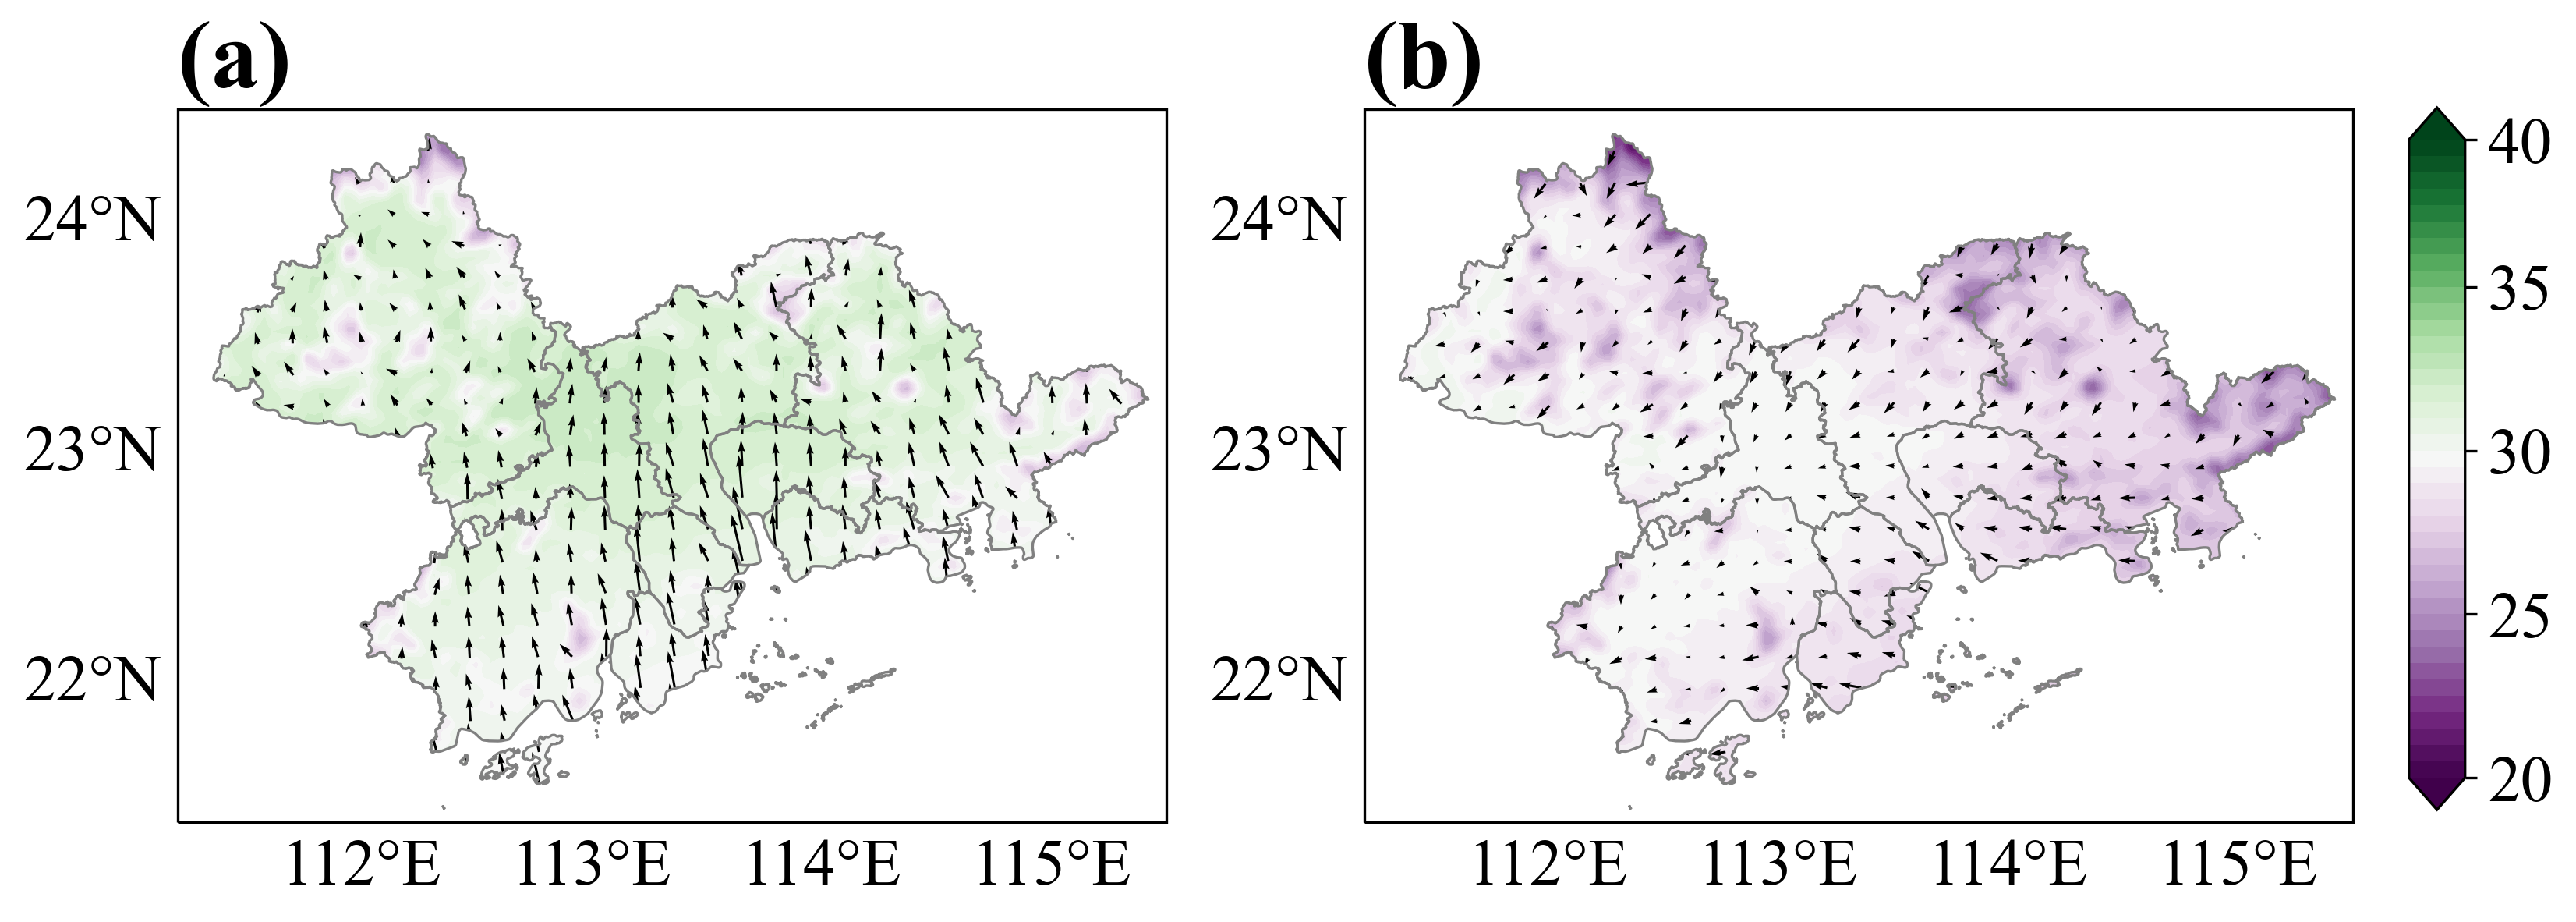

In [8]:
map_noneobs(avg_summer_uw, cmin, cmax, cmstep, cbstep,
             mean_summer, mean_autumn,uwind_summer, vwind_summer,uwind_autumn, vwind_autumn,
             ngrid=5, scale=100, headwidth=3,
             mapcolor='PRGn',colorbar_label='')

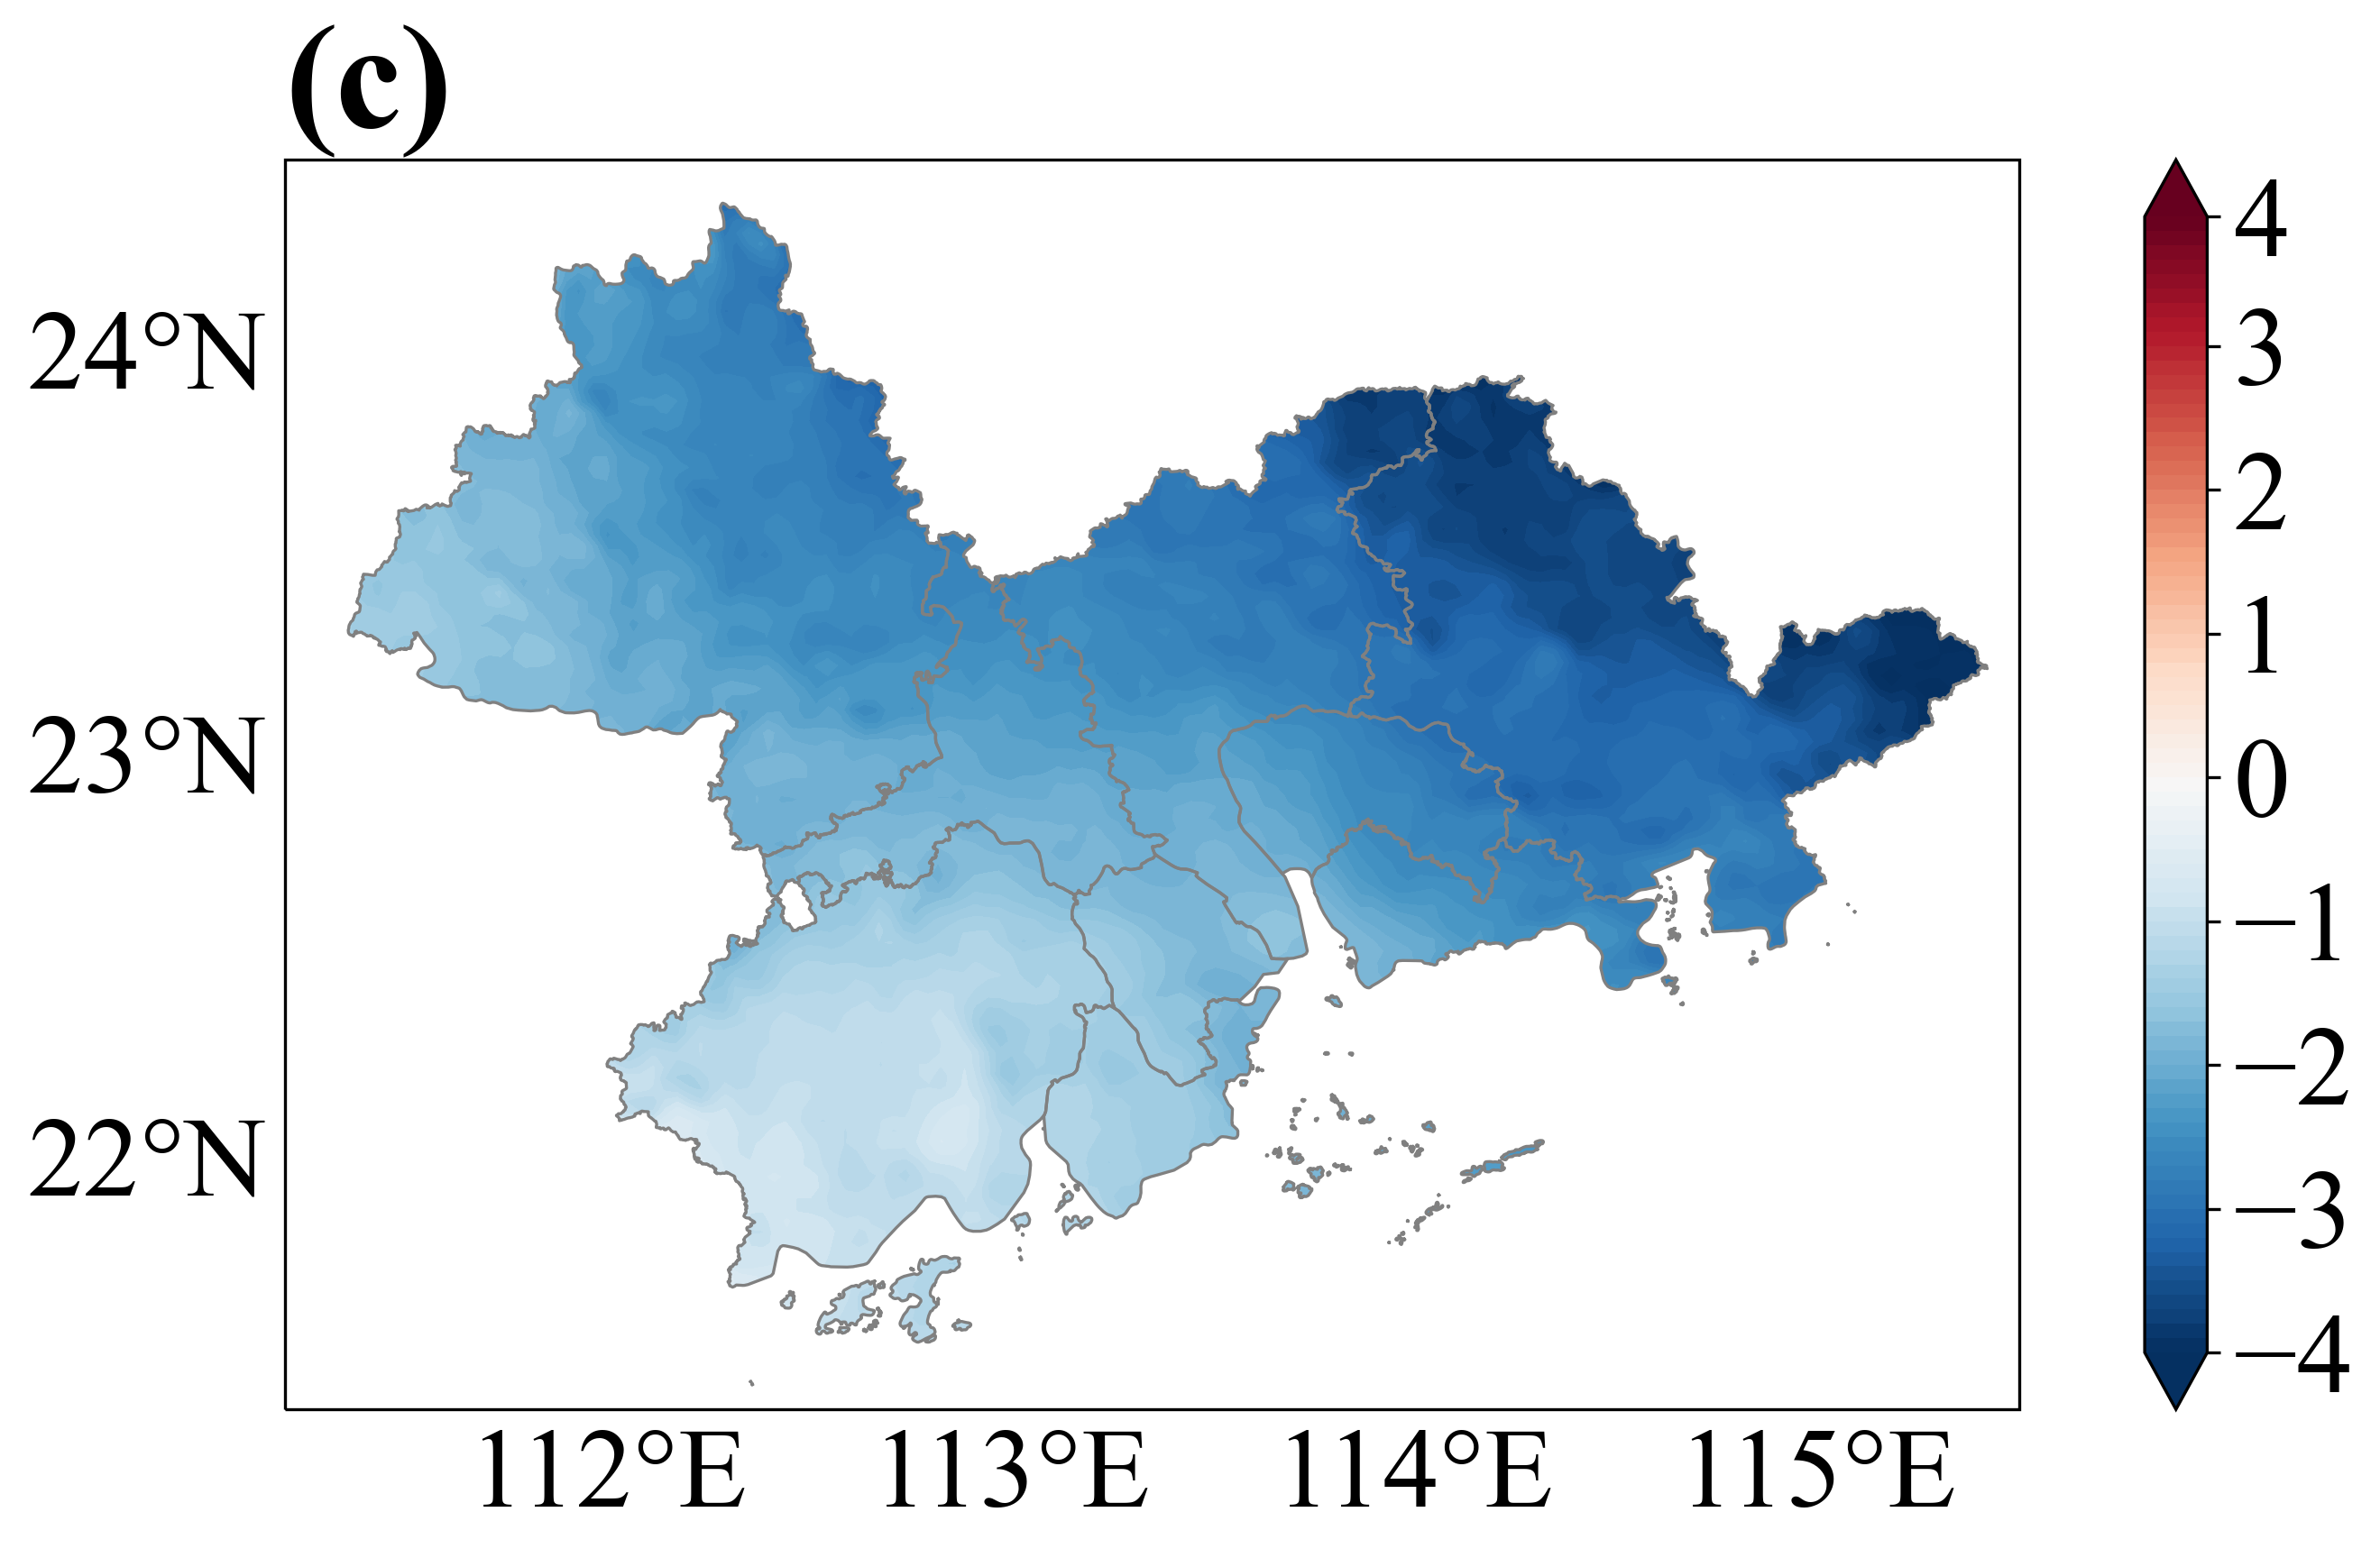

In [9]:
cmin = -4
cmax = 4
cmstep = 0.1
cbstep = 1

diff_noneobs(avg_summer_uw, cmin, cmax, cmstep, cbstep,
              mean_summer, mean_autumn,
              title='(c)', colorbar_label='')